# Loading and the Data preparation



We implement the RBM for Feature Extraction

Training set shape: (800, 20)
Test set shape: (200, 20)
Epoch 10/100, Error: 1.8404
Epoch 20/100, Error: 1.8392
Epoch 30/100, Error: 1.8420
Epoch 40/100, Error: 1.8477
Epoch 50/100, Error: 1.8437
Epoch 60/100, Error: 1.8419
Epoch 70/100, Error: 1.8454
Epoch 80/100, Error: 1.8456
Epoch 90/100, Error: 1.8418
Epoch 100/100, Error: 1.8434

Original dimension: 20
Reduced dimension: 10
Train features shape: (800, 10)
Test features shape: (200, 10)
Skipping n_clusters=2 (only 1 cluster(s) formed)
Skipping n_clusters=3 (only 1 cluster(s) formed)
Skipping n_clusters=4 (only 1 cluster(s) formed)
Skipping n_clusters=5 (only 1 cluster(s) formed)
Skipping n_clusters=6 (only 1 cluster(s) formed)
Skipping n_clusters=7 (only 1 cluster(s) formed)
Could not form multiple clusters with the given data


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:


Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.74      0.53      0.61        59
           1       0.82      0.92      0.87       141

    accuracy                           0.81       200
   macro avg       0.78      0.72      0.74       200
weighted avg       0.80      0.81      0.79       200

ROC AUC: 0.8280


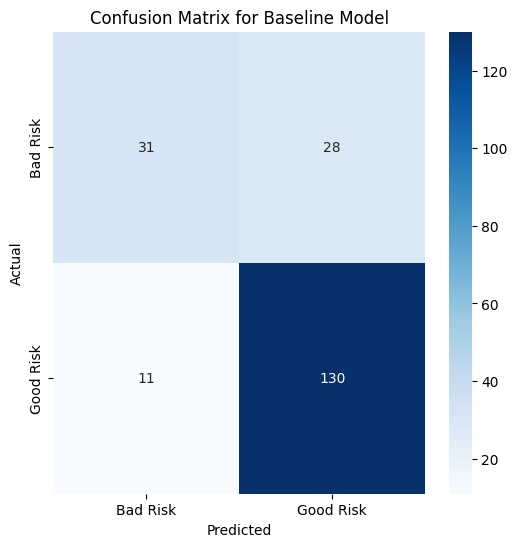


RBM+RF Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.70      1.00      0.83       141

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.50      0.70      0.58       200

ROC AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


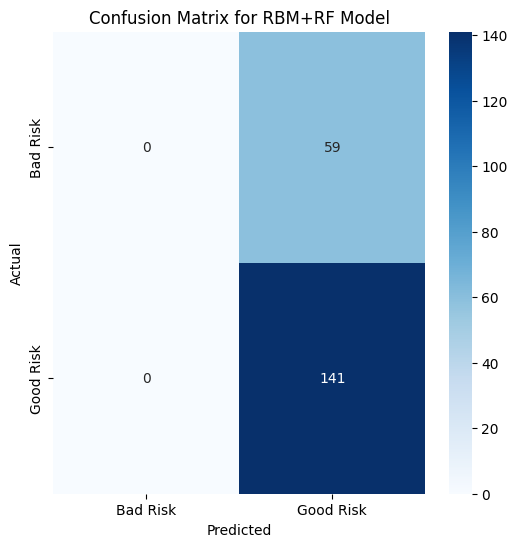

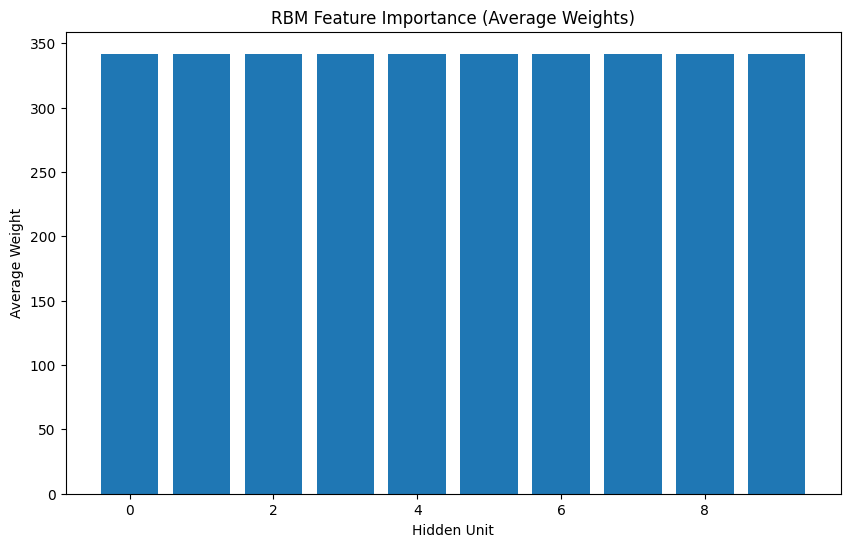


Pipeline Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.70      0.99      0.82       141

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.50      0.70      0.58       200

ROC AUC: 0.4910

Sample Customer Prediction: Approved
Probability: 0.68 (Good Risk), 0.32 (Bad Risk)


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Load the German Credit Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = [
    'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_account', 'employment', 'installment_rate', 'personal_status',
    'other_debtors', 'residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'existing_credits', 'job', 'people_liable', 'telephone', 'foreign_worker',
    'credit_risk'
]

# Load the data
data = pd.read_csv(url, delimiter=' ', header=None, names=column_names)

# Convert target to binary (1 = good, 0 = bad)
data['credit_risk'] = data['credit_risk'].replace({1: 1, 2: 0})

# Separate features and target
X = data.drop('credit_risk', axis=1)
y = data['credit_risk']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64']).columns

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

class RBM:
    def __init__(self, visible_dim, hidden_dim, learning_rate=0.01, k=1):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.k = k

        # Initialize weights and biases
        self.W = tf.Variable(tf.random.normal([visible_dim, hidden_dim], stddev=0.01))
        self.v_bias = tf.Variable(tf.zeros([visible_dim]))
        self.h_bias = tf.Variable(tf.zeros([hidden_dim]))

    def sample_h(self, v):
        # Probability of hidden units given visible units
        h_prob = tf.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        # Sample from Bernoulli distribution
        return tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob))))

    def sample_v(self, h):
        # Probability of visible units given hidden units
        v_prob = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        # Sample from Bernoulli distribution
        return tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob))))

    def contrastive_divergence(self, v):
        # Positive phase
        h_pos = self.sample_h(v)

        # Negative phase (k-step Gibbs sampling)
        v_neg = v
        for _ in range(self.k):
            h_neg = self.sample_h(v_neg)
            v_neg = self.sample_v(h_neg)

        # Update weights and biases
        pos_grad = tf.matmul(tf.transpose(v), h_pos)
        neg_grad = tf.matmul(tf.transpose(v_neg), self.sample_h(v_neg))

        self.W.assign_add(self.learning_rate * (pos_grad - neg_grad))
        self.v_bias.assign_add(self.learning_rate * tf.reduce_mean(v - v_neg, axis=0))
        self.h_bias.assign_add(self.learning_rate * tf.reduce_mean(h_pos - self.sample_h(v_neg), axis=0))

        # Reconstruction error
        error = tf.reduce_mean(tf.square(v - v_neg))
        return error

    def transform(self, v):
        return tf.sigmoid(tf.matmul(v, self.W) + self.h_bias)

# Convert data to numpy arrays
X_train_rbm = X_train.values.astype(np.float32)
X_test_rbm = X_test.values.astype(np.float32)

# RBM parameters
visible_dim = X_train.shape[1]
hidden_dim = 10  # Reduced dimension
learning_rate = 0.01
epochs = 100
batch_size = 32

# Initialize RBM
rbm = RBM(visible_dim, hidden_dim, learning_rate)

# Training loop
num_batches = int(np.ceil(X_train_rbm.shape[0] / batch_size))

for epoch in range(epochs):
    epoch_error = 0
    np.random.shuffle(X_train_rbm)

    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        batch_data = X_train_rbm[start:end]

        error = rbm.contrastive_divergence(batch_data)
        epoch_error += error.numpy()

    epoch_error /= num_batches
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Error: {epoch_error:.4f}")

# Extract features from RBM
train_features = rbm.transform(X_train_rbm).numpy()
test_features = rbm.transform(X_test_rbm).numpy()

print(f"\nOriginal dimension: {visible_dim}")
print(f"Reduced dimension: {hidden_dim}")
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Clustering with improved handling
def perform_clustering(features, max_clusters=7):
    silhouette_scores = []
    valid_cluster_counts = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(features)

        # Only calculate score if we have at least 2 clusters with points
        unique_labels = np.unique(cluster_labels)
        if len(unique_labels) < 2:
            print(f"Skipping n_clusters={n_clusters} (only {len(unique_labels)} cluster(s) formed)")
            continue

        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        valid_cluster_counts.append(n_clusters)
        print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_avg:.4f}")

    if len(valid_cluster_counts) == 0:
        print("Could not form multiple clusters with the given data")
        return None, None, None

    # Plot silhouette scores
    plt.figure(figsize=(8, 5))
    plt.plot(valid_cluster_counts, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different Cluster Numbers')
    plt.grid(True)
    plt.show()

    # Choose optimal number of clusters
    optimal_clusters = valid_cluster_counts[np.argmax(silhouette_scores)]
    print(f"\nSelected optimal number of clusters: {optimal_clusters}")

    # Perform final clustering
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)

    return kmeans, cluster_labels, optimal_clusters

# Perform clustering
kmeans, train_clusters, optimal_clusters = perform_clustering(train_features)

if kmeans is not None:
    test_clusters = kmeans.predict(test_features)

    # Analyze clusters
    cluster_data = X_train.copy()
    cluster_data['cluster'] = train_clusters
    cluster_data['credit_risk'] = y_train.values

    # Calculate mean values for each cluster
    cluster_stats = cluster_data.groupby('cluster').mean()
    print("\nCluster Statistics:")
    print(cluster_stats[['credit_amount', 'age', 'duration', 'credit_risk']])

    # Visualize clusters in 2D using PCA
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(train_features)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_clusters, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Customer Clusters in 2D PCA Space')
    plt.show()

    # Create risk profiles based on clusters
    risk_profiles = []
    for cluster in range(optimal_clusters):
        cluster_samples = cluster_data[cluster_data['cluster'] == cluster]
        profile = {
            'cluster': cluster,
            'size': len(cluster_samples),
            'default_rate': 1 - cluster_samples['credit_risk'].mean(),
            'avg_income': cluster_samples['credit_amount'].mean(),
            'avg_age': cluster_samples['age'].mean(),
            'avg_duration': cluster_samples['duration'].mean()
        }
        risk_profiles.append(profile)

    # Convert to DataFrame for better visualization
    risk_profile_df = pd.DataFrame(risk_profiles)
    risk_profile_df = risk_profile_df.sort_values('default_rate', ascending=False)

    print("\nRisk Profiles by Cluster:")
    print(risk_profile_df)

    # Visualize risk profiles
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='cluster', y='default_rate', data=risk_profile_df, palette='Reds_r')
    plt.title('Default Rate by Cluster')
    plt.ylabel('Default Rate')
    plt.xlabel('Cluster')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='avg_income', y='default_rate', size='size',
                    hue='cluster', data=risk_profile_df, palette='viridis', sizes=(100, 500))
    plt.title('Income vs Default Rate by Cluster')
    plt.xlabel('Average Credit Amount')
    plt.ylabel('Default Rate')

    plt.tight_layout()
    plt.show()

# Model evaluation
def evaluate_model(X_train, y_train, X_test, y_test, name):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Model Performance:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Bad Risk', 'Good Risk'],
                yticklabels=['Bad Risk', 'Good Risk'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name} Model')
    plt.show()

    return model

# Baseline model (without RBM features)
baseline_model = evaluate_model(X_train, y_train, X_test, y_test, "Baseline")

# Model with RBM features
if train_features is not None:
    rbm_model = evaluate_model(train_features, y_train, test_features, y_test, "RBM+RF")

    # Feature importance from RBM
    plt.figure(figsize=(10, 6))
    plt.bar(range(hidden_dim), np.mean(rbm.W.numpy(), axis=0))
    plt.xlabel('Hidden Unit')
    plt.ylabel('Average Weight')
    plt.title('RBM Feature Importance (Average Weights)')
    plt.show()

# Pipeline implementation
class RBMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, visible_dim=None, hidden_dim=10, learning_rate=0.01, epochs=50, batch_size=32, k=1):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.k = k
        self.rbm = None
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Scale data
        X_scaled = self.scaler.fit_transform(X)

        # Initialize RBM
        if self.visible_dim is None:
            self.visible_dim = X.shape[1]
        self.rbm = RBM(self.visible_dim, self.hidden_dim, self.learning_rate, self.k)

        # Convert to numpy array
        X_rbm = X_scaled.astype(np.float32)

        # Training loop
        num_batches = int(np.ceil(X_rbm.shape[0] / self.batch_size))

        for epoch in range(self.epochs):
            np.random.shuffle(X_rbm)
            for batch in range(num_batches):
                start = batch * self.batch_size
                end = start + self.batch_size
                batch_data = X_rbm[start:end]
                self.rbm.contrastive_divergence(batch_data)

        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        X_rbm = X_scaled.astype(np.float32)
        return self.rbm.transform(X_rbm).numpy()

# Create and evaluate the pipeline
pipeline = Pipeline([
    ('rbm', RBMExtractor(hidden_dim=10, epochs=50)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

# Evaluate pipeline
y_pred_pipe = pipeline.predict(X_test)
print("\nPipeline Performance:")
print(classification_report(y_test, y_pred_pipe))
print(f"ROC AUC: {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]):.4f}")

# Example prediction
sample_customer = X_test.iloc[0:1]
prediction = pipeline.predict(sample_customer)
probability = pipeline.predict_proba(sample_customer)[0]

print(f"\nSample Customer Prediction: {'Approved' if prediction[0] == 1 else 'Rejected'}")
print(f"Probability: {probability[1]:.2f} (Good Risk), {probability[0]:.2f} (Bad Risk)")